<a href="https://colab.research.google.com/github/Pepe-Padilla/deep-learning/blob/main/earlyFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Early Fusion - DeepLearning


### Indice
1. Introducción
2. Importación y Normalización de datos
3. Entrenamiento
4. Gráfica de Perdidas
5. Test
6. Concluciones

##  1. Introducción

**Práctica DL** - Ejercicio de Bootcamp Inteligencia Artificial Full Stack Edición III

Este proyecto es un entregable para la práctica del Master Bootcamp Inteligencia Artificial Full Stack Edición III realizado por el centro de formación [@Keepcoding](https://github.com/KeepCoding)

---

El objetivo de este trabajo consiste en resolver un problema del mundo real empleando para ello técnicas vistas durante las sesiones de dicho módulo. En concreto, se trabajará en predecir la condición médica sufrida por una cohorte de pacientes a partir de las diferentes fuentes de información disponibles (imágenes y datos tabulares).

Las imagenes deben entrenar y obtener una de los siguientes respuestas:

| Enfermedad | Descripción | Código | Indice en salida |
|------------|-------------|--------|------------------|
| Actinic keratoses y carcinoma de células escamosas | Tipo de cáncer de piel | akiec | 0 |
| Nevus melanocítico | Lesión benigna común | nv | 1 |
| Melanoma | Tipo de cáncer de piel agresivo | mel | 2 |
| Lesiones benignas de queratosis | Incluyen lentigo solar y queratosis seborreica | bkl | 3 |
| Dermatofibroma | Lesión benigna del tejido fibroso | df | 4 |
| Vasculares | Lesiones vasculares como hemangiomas | vasc | 5 |
| Lesión de células basales | Un tipo de cáncer de piel menos agresivo que el melanoma | bcc | 6 |

---

Para el Early Fusion se usará la combinación aprendida de las predicciones realizadas por el modelo 1D y 2D desarrollado previamente.

## 2. Importación y Normalización de datos

### 2.1 Imports

In [ ]:
# 1. Primero las importaciones que necesitaremos
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import RidgeClassifier

### 2.2 Obtención de datos

In [ ]:
# Ignora esta celda tenía una incidencia que ya he resuleto, ver concluciones en D1
import tensorflow as tf
import numpy as np

# Load the model
tabular_model = tf.keras.models.load_model("/content/1d_model.keras")

# Now you can access the input attribute
print(tabular_model.input)


<KerasTensor shape=(None, 19), dtype=float32, sparse=False, name=input_layer_8>


In [ ]:
# 2. Obtención de datos
#dataframe = pd.read_csv("/content/HAM10000_metadata.csv", usecols=[1], engine='python', skipfooter=3)
#df = dataframe.values
df_label = pd.read_csv("/content/HAM10000_metadata.csv", sep=",")
df_image = pd.read_csv("/content/hnmist_28_28_RGB.csv", sep=",")
tabular_model = tf.keras.models.load_model("/content/1d_model.keras")
image_model = tf.keras.models.load_model("/content/2d_model.keras")


### 2.3 Inspección de elementos

In [ ]:
# 2. Inspección de los datos
print(df_image.head())
print(df_image.info())
print(df_label.head())
print(df_label.info())

# Tratamiento df_label
# Solo age tiene null, solo se me ocurre rellenar con la mediana
df_label["age"] = df_label["age"].fillna(df_label["age"].median())
df_label['age'] = df_label['age'] / 100  # Escalamos considerando 100 como el máximo teórico

# para evitar problemas después, convertir el tipo de age a un float compatible para Tensor
df_label['age'] = df_label['age'].astype('float32')

# Convertimos las variables 'sex' y 'localization' a categorías one-hot encoding
df_label = pd.get_dummies(df_label, columns=['sex', 'localization','dx'])

# 4. Separamos datos
dropX = ['lesion_id','image_id','dx_akiec','dx_bcc','dx_bkl','dx_df','dx_mel','dx_nv','dx_vasc','dx_type']
dropY = ['lesion_id','image_id','dx_type','age','sex_female','sex_male','sex_unknown','localization_abdomen','localization_acral','localization_back','localization_chest','localization_ear',
  'localization_face','localization_foot','localization_genital','localization_hand','localization_lower extremity',
  'localization_neck','localization_scalp','localization_trunk','localization_unknown','localization_upper extremity']
x_label = df_label.drop(dropX, axis=1).astype(np.float32).values  # Convertimos todo a float32
y = df_label.drop(dropY, axis=1).astype(np.float32).values  # Convertimos todo a float32

# 3. Preprocesamiento
# Separación de características e imágenes
X = df_image.values  # Extraemos los valores de píxeles
X = X.reshape(-1, 28, 28, 3)  # Reestructuramos a formato de imagen (28x28x3)
x_image = X.astype(np.float32) / 255.0  # Normalización de valores RGB




   pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2342  pixel2343  \
0        197        154        185        202  ...        134        173   
1        123         93        126        158  ...         82         60   
2        201        142        160        206  ...        149        167   
3        143        103        119        171  ...         73         44   
4        215        162        191        225  ...        201        209   

   pixel2344  pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  \
0        124        138        183        147

### 2.4 Separación de datos

In [ ]:
# 4. Separación de datos
X_label_train, X_label_test, X_image_train, X_image_test, y_train, y_test = train_test_split(
    x_label, x_image, y, shuffle=True, test_size=0.2, random_state=42
)

X_label_train, X_label_val, X_image_train, X_image_val, y_train, y_val = train_test_split(
    X_label_train, X_image_train, y_train, shuffle=True, test_size=0.15, random_state=42
)

### 2.5 Verificación

In [ ]:
# 5. Verificación de normalización
y_traindf = pd.DataFrame(y_train)

print(y_traindf.describe())
print(X_label_train.shape)
print(X_image_train.shape)

                 0            1            2            3            4  \
count  6810.000000  6810.000000  6810.000000  6810.000000  6810.000000   
mean      0.033333     0.052129     0.107342     0.011160     0.109692   
std       0.179524     0.222301     0.309581     0.105058     0.312524   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                 5            6  
count  6810.000000  6810.000000  
mean      0.670485     0.015859  
std       0.470059     0.124940  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       1.000000     0.000000  
75%       1.000000     0.000000  
max       1.000000     1.000000  
(6810, 19)
(6810, 28, 28, 3

## 3. Entrenamiento

In [ ]:
for layer in image_model.layers:
    print(layer.name)


input_layer_3
conv2d_9
batch_normalization_9
activation_9
max_pooling2d_9
dropout_12
conv2d_10
batch_normalization_10
activation_10
max_pooling2d_10
dropout_13
conv2d_11
batch_normalization_11
activation_11
max_pooling2d_11
dropout_14
global_average_pooling2d_3
dense_6
dropout_15
dense_7


In [ ]:
# Definición de las formas de entrada
tabular_input_shape = (19,)
vision_input_shape = (28, 28, 3)

# Initialize tabular_model by calling it with dummy input
dummy_input = np.zeros((1, tabular_input_shape[0]))  # Create dummy input
tabular_model(dummy_input)  # Call tabular_model to initialize input layer

def build_early_fusion_representation(tabular_model, image_model):
    # Entradas
    tabular_input = Input(shape=tabular_input_shape, name="tabular_input")
    vision_input = Input(shape=vision_input_shape, name="vision_input")

    # Modelos intermedios
    tabular_intermediate = Model(
        inputs=tabular_model.input,
        outputs=tabular_model.get_layer('tab_dense2').output
    )
    vision_intermediate = Model(
        inputs=image_model.input,
        outputs=image_model.get_layer('dense_6').output
    )

    tabular_features = tabular_intermediate(tabular_input)
    vision_features = vision_intermediate(vision_input)

    # Fusión de las representaciones de ambas modalidades
    merged = Concatenate()([tabular_features, vision_features])
    merged = Dense(128, activation="relu")(merged)
    merged = Dense(64, activation="relu")(merged)
    merged = Dense(7, activation='softmax', name='tab_output')(merged)

    early_fusion_representation = Model(
        inputs=[tabular_input, vision_input],
        outputs=merged
    )
    return early_fusion_representation

# Crear modelos
model = build_early_fusion_representation(tabular_model, image_model)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(2e-5),
    metrics=['accuracy']
)

n_epochs = 50

# 8. Entrenamiento del modelo
H = model.fit([X_label_train, X_image_train], y_train,
          batch_size=100,
          epochs=n_epochs,
          validation_data=([X_label_val, X_image_val], y_val))

# 9. Evaluación del modelo
scores = model.evaluate([X_label_test, X_image_test], y_test)
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])


Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.4399 - loss: 1.5847 - val_accuracy: 0.6697 - val_loss: 1.0437
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6977 - loss: 0.8557 - val_accuracy: 0.7404 - val_loss: 0.8328
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8035 - loss: 0.6186 - val_accuracy: 0.7712 - val_loss: 0.7140
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8590 - loss: 0.4900 - val_accuracy: 0.7787 - val_loss: 0.6468
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8794 - loss: 0.4089 - val_accuracy: 0.7812 - val_loss: 0.6241
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8963 - loss: 0.3374 - val_accuracy: 0.7920 - val_loss: 0.6050
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9111 - loss: 0.3037 - val_accuracy: 0.7903 - val_loss: 0.6015
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9146 - loss: 0.2802 - val_accuracy: 0.7978 -

## 4. Gráfica de Perdidas

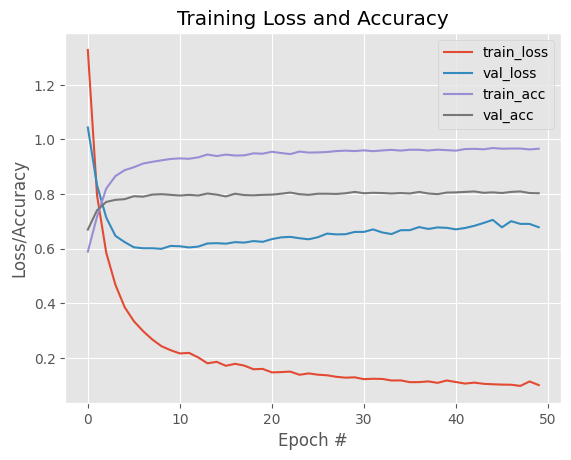

In [ ]:
# veamos nuestra función de pérdidas con respecto a las épocas ejecutadas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
# Guardamos el resultado
model.save("/content/earlyfusion_model.keras")

## 5. Concluciones

In [ ]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 19)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_input (InputLayer) │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_7 (Functional) │ (None, 16)             │            880 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_8 (Functional) │ (None, 1024)           │        432,384 │ vision_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1040)           │              0 │ functional_7[0][0],    │
│ (Concatenate)             │                        │                │ functional_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        133,248 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tab_output (Dense)        │ (None, 7)              │            455 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,724,135 (6.58 MB)

 Trainable params: 574,455 (2.19 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 1,148,912 (4.38 MB)

Durante el desarrollo de este modelo multimodal usando early fusion, el objetivo principal fue integrar datos tabulares y visuales (imágenes) en una sola arquitectura que permitiera aprovechar lo mejor de ambos mundos. A lo largo del proceso, se identificaron varios retos técnicos, especialmente relacionados con la estructura de los modelos de entrada y la compatibilidad de sus arquitecturas para una fusión efectiva.

Uno de los principales obstáculos fue que tanto el modelo tabular como el de imágenes estaban construidos utilizando la API Sequential, lo cual limita la flexibilidad a la hora de hacer fusiones intermedias o acceder a capas específicas. Esto provocó errores durante la construcción del modelo de fusión y durante el entrenamiento, ya que Keras no podía gestionar adecuadamente múltiples entradas ni acceder correctamente a las salidas intermedias necesarias para la concatenación.

La solución consistió en reconstruir ambos modelos usando la API funcional de Keras, lo que permitió seleccionar capas intermedias como puntos de salida (tab_dense2 en el modelo tabular, por ejemplo), y fusionarlas correctamente. Este cambio fue clave para lograr que el modelo final compilara y entrenara sin errores.

Además, se comprobó empíricamente que usar la última capa como punto de fusión no siempre es lo ideal, ya que puede estar demasiado especializada en la tarea individual del submodelo. Al utilizar una capa intermedia (como tab_dense2), se logra una representación más rica y general que permite a la red combinada aprender de forma más eficaz.

